<a href="https://colab.research.google.com/github/WCSCourses/CRISPR_informatics_2025/blob/2025_updates/course_data_2025/CRISPR_Screening_data/crispr_counts_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High-content CRISPR screens: how to survey the genome



-------
# Table of contents
<a name="toc"></a>

1. [Introduction and aims](#intro)
2. [Today's exercise](#exercise)
3. [Step 1: Installing software and importing data for our session](#step1)
4. [Step 2: Exploring a "raw" counts dataset](#step2)
5. [Step 3: Identifying significantly perturbed genes in the screen](#step3)
6. [Step 4: Validating the results of a CRISPR screen](#step4)
7. [Step 5: Alternative CRISPR analysis tools](#step5)
8. [Step 6: Biolocial considerations in screen interpretation](#step6)
9. [Summary](#summary)
10. [References](#references)

-----

<a name="intro"></a>
# Introduction and aims



The aim of this practical class is to introduce you to some of the concepts and tools involved in the analysis of pooled CRISPR screens. We will begin by taking a set of pre-generated CRISPR counts data and exploring it in R. Then, we will process the dataset to identify essential genes in a cell line using a two popular tools: MAGeCK and BAGEL2. Finally, we will explore some of the pitfalls that you might need to considere when interpeting the results of CRISPR screening experiments.

----

### Background
<a name="background"></a>

Throughout this course, you will hopefully have seen how CRISPR systems can be applied as powerful tools for cellular manipulation. Depending on how they are configured, CRISPR systems can be used to:

- Introduce double-stranded breaks at a genomic locus
- Introduce sequence modifications to a locus
- Recruit functional domains to that locus
- Modulate gene expression (activation with CRISPRa and inhibition with CRISPRi)


CRISPR screens attempt to perform these manipulations at scale: interrogating thousands of genomic features (genes, promoters, enhancers *etc.*) simultaneously. **Pooled screens** enable us to achieve this within a single population of cells, hugely simplifying candidate gene discovery.

----
### The CRISPR screening process

The process of conducting a pooled CRISPR screen is illustrated below in Figure 1. Essentially, we aim to deliver a "library" of guide RNAs into a population of cells expressing Cas9 and observe the effects. It can be broken down into the following steps:

🧬 **Design** 🧬

First, we construct a library of guide RNAs that target your sequences of interest. You might be able to order an off-the-shelf pre-designed library for this (popular libraries include Avana, Yusa v1.1, and TKOv3); you might have to design and synthesise a library of your own. While we won't cover the custom gRNA library design process in detail in this session, I'd recommend looking at the [CRISPRverse](https://github.com/crisprVerse/Tutorials/tree/master) collection of R packages. They have several helpful tutorials that walk you through custom gRNA library design.

📦 **Delivery** 📦

You will now need to deliver your guide RNA library into your cells of interest. A popular means for doing this is to package your library into lentiviral vectors and then transduce your cells. If you aim for a low multiplicity of infection (MOI), you should be able to effectively introduce a single guide RNA into each cell in the population. This reduces the possibility of cells recieving multiple guides and double cutting events.

 🥼 **Cell Culture and Phenotypic Selection** 🥼

You can now subject your diversified cell population to some sort of selective pressure. This might be just survival in the presence of CRISPR-Cas9, survival in the presence of a drug, or the expression of a fluorescent reporter (measured with a flow cytometer). Typically, you would culture cells for multiple passages under selection to allow time for CRISPR-mediated genetic modifications and to amplify phenotypic effects.


💻 **Genomic DNA Extraction and Sequencing** 💻

Finally, you will need to amplify guide plasmid DNA from both your selected and control cell populations using PCR. If you perform high-throughput sequencing to quantify gRNA abundance, you can then compare guide RNA counts in a selected and control population of cells. This should reveal which guides (and by proxy which target sequences) are associated with the phenotype.

----


----
**Figure 1. Process diagram for a CRISPR screen**

![Figure 1. Process diagram for a CRISPR screen](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/CRISPR_screen_demo.jpg?raw=1)

Taken from [Clark, Teleri et al.
Trends in Biotechnology, Volume 42, Issue 8, 1017 - 1034](https://www.cell.com/trends/biotechnology/fulltext/S0167-7799(24)00036-2)

-----

Screens can be classified as:

- **Knockout screens**: Identify essential genes or genes involved in specific phenotypes
- **Activation screens**: Uncover genes that, when overexpressed, contribute to a phenotype
- **Inhibition screens**: Reveal genes that, when repressed, affect a particular cellular process

At the Wellcome Trust Sanger Institute we conduct large-scale CRISPR knockout screens of cancer cell lines in collaboration with the Broad Institute  for initiatives such as DepMap to better understand the genetic dependencies of cancer. [Feel free to look around at the results!](https://score.depmap.sanger.ac.uk/)

**Figure 2. The Project Score portal**

![Figure 2. Project score ](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/project_score.png?raw=1)

----


# Today's exercise
<a name="exercise"></a>

Today, we will explore the results of a simple CRISPR knockout screen designed to identify essential genes in the HAP1 cell line. HAP1 is a human myeloid leukemia cell line derivative that is notable for containing approximately 1 copy of each gene: it is near haploid ([Andersson et al., 1987](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10020200/#B2)). HAP1 has become particularly popular within the field of gene editing as it avoids some of the challenges associated with interpreting experiments in diploid cells, such as mixed penetrance of genome editing.


**Figure 3. Karyotype of the HAP1 cell line**

![Figure 3. HAP1 karyotype](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/HAP1_cell_karyotype.png?raw=1)

https://commons.wikimedia.org/wiki/File:HAP1_cell_karotype.png




**Experimental Design**

The screen we will examine today is a straightforward experiment involving just four samples:

- T0 Sample: A single "pre-screen" cell population sample. Collected before CRISPR-Cas9 cutting should have occurred (*serves as a baseline for guide RNA distribution measurements*).


- T18 Samples: Three post-screen samples (A, B, and C). Collected 18 days after the screen began (*represents the cell populations after CRISPR-mediated gene knockout and selection*).

To perform the experiment, HAP1 cells were transfected with the [TKO_V3 library](https://www.addgene.org/pooled-library/moffat-crispr-knockout-tkov3/) which contains more than 70,000 guides targeting >18,000 genes.

**Data Analysis Approach**

We will:
- Evaluate the quality of HTS-derived samples based on gRNA count statistics ✅
- Compare guide frequencies between T0 and T18 samples ✅
- Use statistical methods to identify significantly depleted or enriched guides ✅
- Map guides to their target genes to identify essential genes in HAP1 ✅

----
<a name="step1"></a>
# Step 1: Installing software and importing data for our session



In order to install some of the tools we will be using in the session, we will first have to add condacolab. Condacolab allows us to install software packages within the code cells of our Google Colab session with the `conda install` command.

In [5]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


Next, we can download the datasets that we're going to use in the exercise. These are:

1. A counts matrix, describing the abundance of guide RNAs at different timepoints in the experiment
2. Two gene lists containing knowon essential and non-essential genes that we will use for validation later in the practical

We will download the data using the `wget` command: which can retrieve any files at a specified web address.




In [6]:
!wget https://raw.githubusercontent.com/WCSCourses/CRISPR_informatics_2025/refs/heads/2025_updates/course_data_2025/CRISPR_Screening_data/reads_hap1.txt
!wget https://raw.githubusercontent.com/WCSCourses/CRISPR_informatics_2025/refs/heads/2025_updates/course_data_2025/CRISPR_Screening_data/CEGv2.txt
!wget https://raw.githubusercontent.com/WCSCourses/CRISPR_informatics_2025/refs/heads/2025_updates/course_data_2025/CRISPR_Screening_data/NEGv1.txt

--2025-07-13 15:40:32--  https://raw.githubusercontent.com/WCSCourses/CRISPR_informatics_2025/refs/heads/2025_updates/course_data_2025/CRISPR_Screening_data/reads_hap1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3649737 (3.5M) [text/plain]
Saving to: ‘reads_hap1.txt.1’

reads_hap1.txt.1    100%[===================>]   3.48M  --.-KB/s    in 0.08s   

2025-07-13 15:40:32 (44.9 MB/s) - ‘reads_hap1.txt.1’ saved [3649737/3649737]

--2025-07-13 15:40:32--  https://raw.githubusercontent.com/WCSCourses/CRISPR_informatics_2025/refs/heads/2025_updates/course_data_2025/CRISPR_Screening_data/CEGv2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (

Next, we will load an extension for the Google Colab notebook that allows us to execute R code within Colab notebook cells. This will enable us to perform our data analysis using R without leaving the Colab environment.
To install and load the R magic for Colab, run the following code in a code cell:

In [7]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


This installs the rpy2 package, which provides a Python interface to R, and then loads the R magic commands for use in Colab.
Now you can use R in your Colab notebook by starting a code cell with the %%R magic command. For example:



In [8]:
%%R
# This is R code
print("Hello from R!")

[1] "Hello from R!"



Now that we've set up the R magic for Colab, any cells that contain the %%R tag at the start will be executed within an R environment. This allows us to seamlessly switch between Python and R code within our notebook.

*Note: Any lines of code that contain an ! at the start will be executed in bash (the default scripting language in a terminal).*

----

Let's begin the exercise by loading a couple of R packages into our Colab session. For those newer to R, we'll be using the tidyverse meta-package: a set of tools that extend "base" R to make data-wrangling and exploration more enjoyable. The code also makes use of the |> pipe functionality in R, which simplifies multi-step data manipulation.
*Note: Some of you might recognize |>'s progenitor – %>% – which was prevalent in older versions of R.*

Here's how we can load the necessary packages:

In [9]:
%%R
# Load our dependencies
suppressMessages(install.packages("ggrepel"))
library(tidyverse)
library(ggrepel)

trying URL 'https://cran.rstudio.com/src/contrib/ggrepel_0.9.6.tar.gz'
Content type 'application/x-gzip' length 149970 bytes (146 KB)
downloaded 146 KB


The downloaded source packages are in
	‘/tmp/Rtmp9TfmX8/downloaded_packages’


Here's how the |> pipe operator is going to let us to chain together multiple operations. It takes the output of one function and passes it to the next function. This can make our code more readable and intuitive, especially when performing several operations on a dataset.

For example, instead of writing:
`result <- function3(function2(function1(data)))`

We can write
```
result <- data |>
  function1() |>
  function2() |>
  function3()
```

-------
<a name="step2"></a>
# Step 2: Exploring a "raw" CRISPR counts dataset

We will begin from a point where we already have a CRISPR counts table generated. In your own experiments, you will have to generate this table for yourself. There are several tools for doing this. For example MAGeCK - which we will use soon has an in built counts generation function. However, counts generation requires some large files and computational time that won't be practical in this session. Take a look at the MAGeCK documentation if you'd like an intro for one way to do this [after the practical](https://sourceforge.net/p/mageck/wiki/usage/#count). I'd also recommend taking a look at [LUCA](https://github.com/cancerit/LUCA) WTSI's latest CRISPR counting tool which can be configured for multi-guide RNA experiments (2+ guides per plasmid) and alternative CRISPR-Cas systems.

**Reading counts into R**

Let's read the pregenerated counts file for our experiment into R and display the dataframe that this produces:

In [10]:
%%R
input_file <- read_tsv("reads_hap1.txt")
input_file

Rows: 71090 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): SEQUENCE, GENE
dbl (4): HAP1_T0, HAP1_T18A, HAP1_T18B, HAP1_T18C

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 71,090 × 6
   SEQUENCE             GENE  HAP1_T0 HAP1_T18A HAP1_T18B HAP1_T18C
   <chr>                <chr>   <dbl>     <dbl>     <dbl>     <dbl>
 1 ACTGGCGCCATCGAGAGCCA A1BG      239       245       230        62
 2 CAAGAGAAAGACCACGAGCA A1BG     1647       415       313       394
 3 GCTCAGCTGGGTCCATCCTG A1BG     1480       492       388       415
 4 GTCGAGCTGATTCTGAGCGA A1BG      888       387       297       202
 5 AGTTATGTTAGGTATACCCG A1CF      266       176       327       328
 6 ATGACTCTCATACTCCACGA A1CF      294       183       254       131
 7 GGTGCAGCATCCCAACCAGG A1CF      307       314       143       186
 8 TGCGCTGGACCAG

----

**Anatomy of the dataset**

The dataframe has several columns:
- `SEQUENCE`: representing the CRISPR guide RNA sequences used in the screen
- `GENE`: representing the genes targeted by each guide RNA
- Several sample columns (`HAP1_T0`, `HAP1_T18A`, etc.): representing the count data for each sample in the experiment

The `HAP1` in these sample names reflects the cell line we screened in the experiment, and the `T<X>` reflects the timepoint at which the sample was collected.

### Questions to consider i)

1. You might notice that there are multiple guide RNA sequences per gene. Why do you think this might be the case?

2. In some cases, the sequence counts vary widely between the T18 A, B, and C replicates. Can you think of any explanations for this variability?

Take a moment to think about these questions. We'll discuss them further as we progress through the analysis.

**Reformatting the data**

The dataframe we've read into R has several columns representing guide RNA counts. For downstream analysis in R, it will be helpful to "wrangle" our data into what's called a [tidy format](https://r4ds.had.co.nz/tidy-data.html). We will do that here, collapsing all of our HAP1 columns into one with a command called a `pivot`.

Here's how we can reformat our data:


In [11]:
%%R
guide_counts <- input_file |>
                pivot_longer(cols = contains("HAP1"),
                             values_to = "counts",
                             names_to = "sample")

Now that we have reformatted our dataset into a tidy format, let's take a look at the first few lines of our new, easier-to-explore dataframe:




In [12]:
%%R
head(guide_counts)

# A tibble: 6 × 4
  SEQUENCE             GENE  sample    counts
  <chr>                <chr> <chr>      <dbl>
1 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T0      239
2 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18A    245
3 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18B    230
4 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18C     62
5 CAAGAGAAAGACCACGAGCA A1BG  HAP1_T0     1647
6 CAAGAGAAAGACCACGAGCA A1BG  HAP1_T18A    415


**Exploring the dataset**

We can visualise this reformatted dataset to better understand the distribution of guide counts in a sample.

For a typical genome-wide CRISPR screen, we would hope that all guide sequences are observed in our sample (with counts > 0) and that there is sufficient sequencing depth (coverage) for each guide in the library to allow us to perform statistical tests with downstream tools. Let's check this now using a boxplot.

A boxplot presents the dataset concisely, highlighting the following: the mean counts per guide in each sample, the upper and lower limits for the guide counts in each sample (represented by the boundaries of the boxes), and any guides with extremely high or low counts, which are flagged as dots.

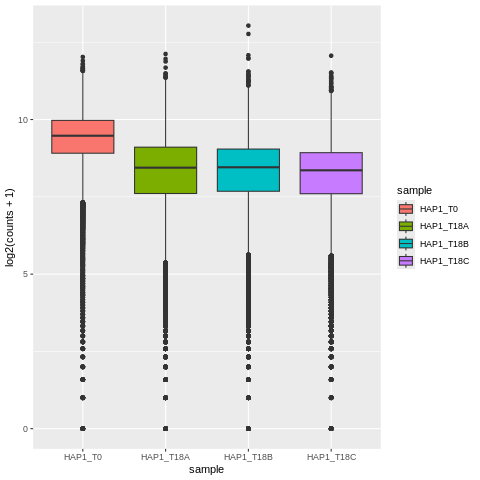

In [13]:
%%R

ggplot(guide_counts, aes(x = sample, y=log2(counts+1))) +
geom_boxplot(aes(fill = sample))

We can also re-plot the distribution of counts for the different guides in the screen using a density plot. This plot should tell a similar story, but some of you might find it more intuitive.



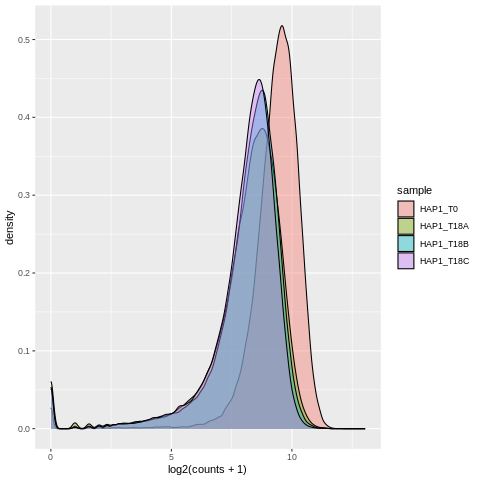

In [14]:
%%R
ggplot(guide_counts, aes(x=log2(counts+1))) +
geom_density(aes(fill = sample), alpha = 0.4)

### Questions to consider ii)
- Notice that we have chosen to represent the counts for the guide RNAs on a log2(counts + 1) scale. Why do you think this might be?
- What do you estimate the mean number of counts per guide RNA is in our samples?
- Most protocols suggest that a mean of at least 200 counts per guide should be sufficient for conducting a CRISPR knockout screen. Do these samples meet that criterion?
- How could you identify poor-quality or outlier samples in a dataset like this? Are you aware of any techniques for this?
- If you had a library of 100,000 gRNAs and wanted a minimum of 500 cells recieving each guide, how many cells would you need to transduce (assuming each cell recieves 0.8 guides)?

---


In [ ]:
%%R
## If you're an R pro and you'd like to try exactly calculating the mean number of counts per guide
## in each sample, here's a space to do so

------
 <a name="step3"></a>
# Step 3: Identifying significantly perturbed genes in the screen

**MAGECK**

Since our data appears to be of suitable quality for downstream processing, we will now try to identify which genes are essential in the HAP1 cell line by comparing samples over the course of the experiment.

To do this, we will use [MAGECK](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0554-4), a popular tool for CRISPR counts analysis that employs a negative binomial (NB) model to identify significantly perturbed genes in a dataset.

In brief, MAGECK will:

- Median-normalise the dataset (to account for differences in sequencing depth between samples),
- Model the mean-variance trend in the dataset (to better handle guides with very low or very high mean counts),
- Perform statistical testing and appropriate corrections to identify guides with significantly different counts at the start and end of the screen.


**Figure 4: Data processing in MAGECK**

![Figure 4: MAGECK processing](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/MAGECK_processing.png?raw=1)

Taken from: Li, W., Xu, H., Xiao, T. et al. MAGeCK enables robust identification of essential genes from genome-scale CRISPR/Cas9 knockout screens

----
This process will generate a "log fold change" value for each guide in the dataset (a measure of effect size — how much the guide counts change by in the treatment) and a *p-value* (a measure of our statistical confidence that the change isn't simple due to chance). Roughly speaking, p-values are determined by both the average log fold change observed for a guide, and the degree of variability between replicates.


**Setting up MAGECK**

We can start using MAGECK by installing it through conda. Ordinarily, this would print a long message about the installation process in the cell below. To keep things readable, we will silence the next cell by redirecting its output to a "black hole" in the computer terminal using
 `&> /dev/null`

Installing should take about a minute. Feel free to read on!



In [15]:
!conda install bioconda::mageck &> /dev/null

**Verifying the installation has worked**

Once the above cell has finished executing (the circle stops spinning) you should be able to verify that MAGECK is installed and view the tool's options by using the -h (help) flag.

In [ ]:
!mageck -h

usage: mageck [-h] [-v] {count,test,pathway,plot,mle} ...

mageck: performs sgRNA, gene and pathway analysis on CRISPR-Cas9 screening
data.

positional arguments:
  {count,test,pathway,plot,mle}
                        commands to run mageck
    count               Collecting read counts from fastq files.
    test                Perform statistical test from a given count table
                        (generated by count command).
    pathway             Perform significant pathway analysis from gene
                        rankings generated by the test command.
    plot                Generating graphics for selected genes.
    mle                 Perform MLE estimation of gene essentiality.

options:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit



**How to use MAGECK**

MAGECK has several subcommands that are available to you - the user. Two are relevant to us in this tutorial: one for generating count files like the one we are using (`count`), and another for analyzing them (`test`). Try accessing the help messages for the two MAGECK subcommands mageck count and mageck test by completing the code blocks below. How do they work?

In [ ]:
# Try to access the count help message here

In [ ]:
# Try to access the stat help message here

**Running MAGECK**

Now that MAGECK is installed and ready to run, we need to define the *contrast* we want to perform (comparing our T0 and T18 samples). Using the MAGECK command options, we can do this by specifying our control (c=T0) and treatment samples (t=T18A,T18B,T18C) based on their column positions in the file (starting from 0).


When we run MAGECK, we will also instruct it to name all of the output files `all_vs_control` and to output the "normalised" guide counts it generates to a file using `--normcounts-to-file`.



In [16]:
!mageck test -k reads_hap1.txt -c 0 -t 1,2,3 -n all_vs_control --normcounts-to-file


INFO  @ Sun, 13 Jul 2025 15:49:02: Parameters: /usr/local/bin/mageck test -k reads_hap1.txt -c 0 -t 1,2,3 -n all_vs_control --normcounts-to-file 
INFO  @ Sun, 13 Jul 2025 15:49:02: Welcome to MAGeCK v0.5.9.5. Command: test 
INFO  @ Sun, 13 Jul 2025 15:49:02: Loading count table from reads_hap1.txt  
INFO  @ Sun, 13 Jul 2025 15:49:02: Processing 1 lines.. 
INFO  @ Sun, 13 Jul 2025 15:49:02: Loaded 71090 records. 
INFO  @ Sun, 13 Jul 2025 15:49:02: Loading Rnw template file: /usr/local/lib/python3.11/site-packages/mageck/test_report.Rmd. 
INFO  @ Sun, 13 Jul 2025 15:49:02: Loading R template file: /usr/local/lib/python3.11/site-packages/mageck/plot_template.RTemplate. 
INFO  @ Sun, 13 Jul 2025 15:49:02: Loading R template file: /usr/local/lib/python3.11/site-packages/mageck/plot_template_indvgene.RTemplate. 
INFO  @ Sun, 13 Jul 2025 15:49:02: Loading Rnw template file: /usr/local/lib/python3.11/site-packages/mageck/plot_template.Rnw. 
INFO  @ Sun, 13 Jul 2025 15:49:02: Treatment samples:

**Results**

As this block of code executes, it will progressively generate several files as the steps of the MAGECK process complete. One of the first files generated will be a `.normalized.txt` file, which contains recalculated guide counts from median normalisation. Median normalisation helps control for differences in the total number of sequencing reads between samples (e.g., if you had accidentally generated 1.5 million reads for one sample and 1 million reads for the others).

Let's visualise this file and the results of normalisation in R:

Rows: 71090 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): sgRNA, Gene
dbl (4): HAP1_T0, HAP1_T18A, HAP1_T18B, HAP1_T18C

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


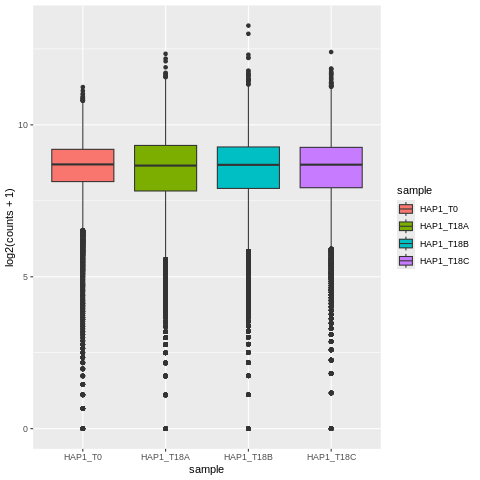

In [17]:
%%R
normalised_counts <- read_tsv("/content/all_vs_control.normalized.txt") |>
                     pivot_longer(cols = contains("HAP1"),
                                  values_to = "counts",
                                  names_to = "sample")

ggplot(normalised_counts, aes(x = sample, y=log2(counts+1))) +
geom_boxplot(aes(fill = sample))




---
### Questions to consider iii)
- If you look back at the boxplots of the raw guide counts that we generated earlier, how has median normalisation affected the dataset?
---

**Summary files**

The next two outputs from the tool that are worth inspecting are the guide-level and gene-level summaries.

**Guide-level summary**

The guide-level summary tells us the extent to which each guide RNA was depleted or enriched during the screen. We can examine the most depleted guides from the library like so:



In [18]:
%%R
read_tsv("/content/all_vs_control.sgrna_summary.txt") |>
filter(LFC < 0) |>
select(sgrna, Gene, control_mean, treat_mean, LFC, FDR) |>
arrange(FDR)

Rows: 71090 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): sgrna, Gene, treatment_count
dbl (11): control_count, control_mean, treat_mean, LFC, control_var, adj_var...
lgl  (1): high_in_treatment

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 35,546 × 6
   sgrna                Gene     control_mean treat_mean    LFC        FDR
   <chr>                <chr>           <dbl>      <dbl>  <dbl>      <dbl>
 1 CGGCGGCTCCCACTCACCCA CPSF3L          1558.       15.2  -6.58 0.00000269
 2 CGAGCTCAAGACCTACCACG PRPF38B         1254.        0   -10.3  0.00000361
 3 TCAGACAGGTGACAGGCCCG WDR18           1667.       92.6  -4.15 0.0000104 
 4 CGACAAGATGGCCACACCGG EIF3F           1475.       37.5  -5.26 0.0000145 
 5 CGAAGTCAAAGCCACCACTG WDR25           1586.       78.6  -4.32 0.0000155 
 6 ACTCTCCTCAGATGCCGCCA NPLOC

How could you revise that code snippet to return the most significantly enriched guides in the experiment? How about the guides with the largest changes in abundance?

In [ ]:
# Enter your solution here

Remember, in these results files, LFC (Log Fold Change) represents the magnitude of depletion or enrichment of a guide (effect size); FDR represents our level of statistical confidence that the depletion or enrichment is not due to random chance. FDR stands for "False Discovery Rate," and here it refers to the adjusted p-value, corrected using the Benjamini-Hochberg method. This correction is commonly applied to p-values in large bioinformatics datasets to account for a statistical issue called "multiple testing.

**Gene-level summary**

The gene-level summary file tells us which genes are the most strongly perturbed in the screen:


In [19]:
%%R
read_tsv("/content/all_vs_control.gene_summary.txt")

Rows: 18056 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): id
dbl (13): num, neg|score, neg|p-value, neg|fdr, neg|rank, neg|goodsgrna, neg...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 18,056 × 14
   id        num  `neg|score` `neg|p-value` `neg|fdr` `neg|rank` `neg|goodsgrna`
   <chr>   <dbl>        <dbl>         <dbl>     <dbl>      <dbl>           <dbl>
 1 POLR2L      4      3.85e-9   0.000000274   0.00103          1               4
 2 EIF3A       4      2.08e-8   0.000000274   0.00103          2               4
 3 GTPBP10     4      7.41e-8   0.000000274   0.00103          3               4
 4 PES1        4      9.76e-8   0.000000274   0.00103          4               4
 5 MRPL53      4      1.35e-7   0.000000823   0.00103          5               4
 6 TCEB2       4      1.36e-7   0.000000

These gene-level statistics are generated in MAGECK by combining the results from multiple guides in the library that target the same gene. In this way, genes where multiple guides show large perturbations will have higher summary scores.


----
### Questions to consider iv)
- Take a look at the top genes reported in the cell above and perform a quick internet search for them in another tab. Does their behaviour in the screen align with what you would expect based on their known functions?

----


If we were to pick out a particular gene (*e.g. PRPF38B*) and examine the counts for that guides that target it across different samples, we should observe a similar pattern: guide counts dropping over the screen.

Rows: 71090 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): sgRNA, Gene
dbl (4): HAP1_T0, HAP1_T18A, HAP1_T18B, HAP1_T18C

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


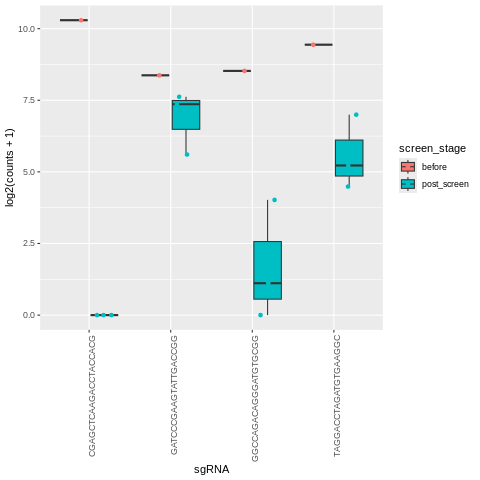

In [20]:
%%R

normalised_counts <- read_tsv("/content/all_vs_control.normalized.txt") |>
                     pivot_longer(cols = contains("HAP1"),
                                  values_to = "counts",
                                  names_to = "sample")
genewise_counts <- normalised_counts |>
filter(Gene == "PRPF38B") |>
mutate(screen_stage = case_when(sample == "HAP1_T0" ~ "before",
                                TRUE ~ "post_screen"))
genewise_counts

ggplot(genewise_counts, aes(x= sgRNA, y = log2(counts + 1))) +
geom_boxplot(aes(fill = screen_stage)) +
geom_jitter(data = genewise_counts, aes(x = sgRNA, y = log2(counts+1), color = screen_stage),
            position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.7)) +
theme(axis.text.x = element_text(angle = 90, hjust = 1))


This looks to be the case! Note that the depletion for the different guides targeting the gene differs. Any ideas why?

In [ ]:
# Why not try adapting the code to another gene

**How summarising across guides works**

Summarising across genes in MAGECK is achieved using a technique called Robust Rank Aggregation (RRA). RRA organises guides into a list according to their *p-value* for depletion or enrichment. In the figure below, this means that the most significantly depleted guides (with the smallest *p-values*) are placed on the left-hand side of the list. The algorithm then looks for genes whose guides are not evenly distributed throughout the list (e.g., a gene whose guides are all perturbed, with *p-values* clustered on the left-hand side).

**Figure 5: Robust Rank Aggregation**

![Figure 5: Robust Rank Aggregation](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/robust_rank_aggregation.png?raw=1)



You can actually go one step further and use RRA (or similar methods) to summarise results across **genes** to find biological pathways or processes that are essential to a cell. This requires labelling genes with their known functions from a database like [Reactome](https://reactome.org/PathwayBrowser/).


---
<a name="step4"></a>
# Step 4: Validating the results of our screen  

Everything looks good so far, but how can we be sure that our screen worked as expected?

In other experimental methods, you would typically use positive and negative controls to check that everything behaved as anticipated. We can do the same in a CRISPR screen by including built-in controls within the library.

- For a negative control, we can examine the behaviour of guides that target known Non-essential genes (NEGs).
- For a positive control, we can assess the behaviour of guides targeting known Common essential genes (CEGs), which in previous experiments have been shown to cause cell death when targeted.

Now, let's read in some files containing these genes and label the genes in our CRISPR dataset according to their expected behaviour.

In [21]:
  %%R
non_essential <- read_tsv("/content/NEGv1.txt") |>
select(GENE) |>
mutate(type = "non-essential")

essential <- read_tsv("/content/CEGv2.txt") |>
select(GENE) |>
mutate(type = "common-essential")


essentiality_class <- bind_rows(non_essential, essential)
essentiality_class


Rows: 927 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): GENE, HGNC_ID
dbl (1): ENTREZ_ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 684 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): GENE, HGNC_ID
dbl (1): ENTREZ_ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 1,611 × 2
   GENE   type         
   <chr>  <chr>        
 1 ABCG8  non-essential
 2 ACCSL  non-essential
 3 ACTL7A non-essential
 4 ACTL7B non-essential
 5 ACTL9  non-essential
 6 ACTRT1 non-essential
 7 ADAD1  non-essential
 8 ADAM18 non-essential
 9 ADAM2  non-essential
10 ADAM20 non-essential
# ℹ 1,601 more rows
# ℹ Use `print(n = ...)` to see more row

Executing the code above provides us with a dataframe in R that describes which genes are essential and which are non-essential. Now, let's add this information to our gene-level dataset to explore which types of genes are among the most depleted.

We can link the two datasets using an operation called a join, where rows with matching "keys"—in this case, gene names—are merged.



In [22]:
%%R
gene_summary_data <- read_tsv("/content/all_vs_control.gene_summary.txt")

annotated_data <- left_join(gene_summary_data, essentiality_class, by = c("id" = "GENE"))


# Let's print the most depleted genes in the screen and their predicted functions
annotated_data |>
select(id, type, `neg|score`, `neg|fdr`)

Rows: 18056 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): id
dbl (13): num, neg|score, neg|p-value, neg|fdr, neg|rank, neg|goodsgrna, neg...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 18,057 × 4
   id      type               `neg|score` `neg|fdr`
   <chr>   <chr>                    <dbl>     <dbl>
 1 POLR2L  common-essential 0.00000000385   0.00103
 2 EIF3A   common-essential 0.0000000208    0.00103
 3 GTPBP10 <NA>             0.0000000741    0.00103
 4 PES1    <NA>             0.0000000976    0.00103
 5 MRPL53  common-essential 0.000000135     0.00103
 6 TCEB2   <NA>             0.000000136     0.00103
 7 MTG2    common-essential 0.000000164     0.00103
 8 CHORDC1 <NA>             0.000000175     0.00103
 9 RPSA    <NA>             0.000000183     0.00103
10 POLR3H  common-essential 0.000000

---
### Questions to consider v)
Take a look at the annotations given to the top most depleted genes Do they line up with what you'd expect?

---

### A more quantitative approach to screen QC

We can quantify the success of a screen by comparing the degree to which common essential genes are depleted relative to non-essential genes. At WTSI, we frequently use a summary statistic called the Null Normalised Mean Difference (NNMD) for this purpose. Essentially, a more negative NNMD in a CRISPR screen indicates a greater separation in behaviour between core essential and non-essential genes.


It is calculated as:

$$
\text{NNMD} = \frac{\text{Mean(LFC_CEGs)} -\text{Mean(LFC_NEGs)}}{\text{Std-dev(LFC_NEGs)}}
$$


So, when we calculate the NNMD of this screen by running the code block below, we get a value of...



In [23]:
%%R
  # Calculate nnmd
  nnmd <- annotated_data |>
    dplyr::rename(LFC = `neg|lfc`) |>
    group_by(type) |>
    summarise(mean_lfc = mean(LFC), sd_lfc = sd(LFC)) |>
    pivot_wider(names_from = type,
                values_from = c(mean_lfc, sd_lfc)) |>
    mutate(nnmd = (`mean_lfc_common-essential` - `mean_lfc_non-essential`) /
                 `sd_lfc_non-essential`) |>
    mutate(nnmd_label = sprintf('NNMD = %.2f', nnmd))
  nnmd |> select(nnmd)

# A tibble: 1 × 1
   nnmd
  <dbl>
1 -7.46


**Results and reflections**

The Cancer Dependency Map requires an NNMD value of -1.0 or lower to consider a screen suitable for further analysis, so the results of this screen are encouraging! Our known essential genes are being depleted 🎉

We can visualise what the NNMD score for the screen represents by plotting the distribution of changes in gRNA counts for our negative and positive control genes. In this plot, the NA genes are those for which the essentiality was not known beforehand.


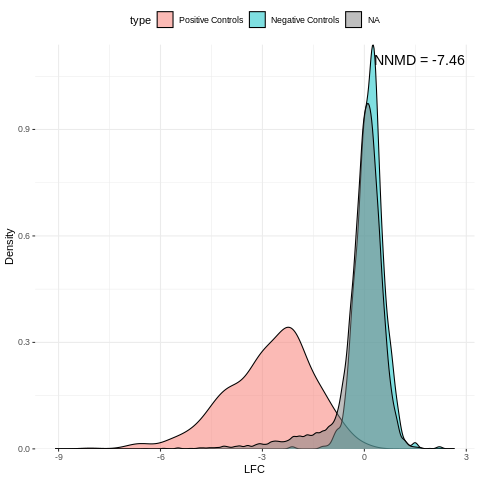

In [24]:

%%R
ggplot(annotated_data, aes(x = `neg|lfc`, fill = type)) +
          geom_density(alpha = 0.5) +
          labs(x = "LFC", y = "Density") +
          theme_bw() +
          theme(legend.position = "top", panel.border = element_blank()) +
          scale_fill_discrete(
            labels = c("Positive Controls", "Negative Controls")
          ) +
          scale_y_continuous(expand = c(0, 0)) +
          annotate(
            "text", x = Inf, y = Inf, label = nnmd[["nnmd_label"]],
            hjust = 1.1, vjust = 2, size = 5, colour = "black"
          )

A bigger NNMD would reflect a larger separation between the negative and postive controls.

----
### Questions to consider vi)
- Looking at the distribution above, what can you infer about the essentiality of the genes with unknown essentiality (NA) in this HAP1 cell line?
- Imagine you were working in a non-model organism and didn't have a list of non-essential genes to use as a negative control. What guides could you use instead?
- Similarly, can you think of an alternative set of guides that you might use as a positive control?

----

Since we now have some confidence that the screen was a success, let's visualise its results with a volcano plot. Volcano plots can be a helpful final-stage visualisation for this kind of data because they display both effect sizes (Log Fold Changes) and statistical confidence measures (p-values). Points towards the top of the volcano plot represent genes with smaller p-values, while points towards the sides represent genes with larger changes in scores. We'll colour genes that pass statistical testing in blue and highlight some of our top genes:

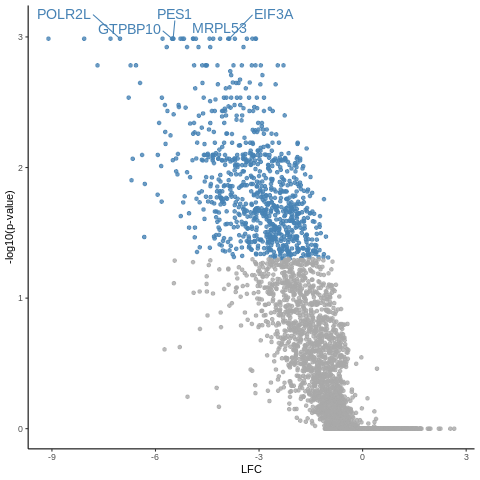

In [25]:

%%R
library(ggrepel)
gene_summary <- annotated_data |>
        mutate(Significant = ifelse(`neg|fdr` < 0.05, "Yes", "No"))

gene_summary_labels <- gene_summary |>
    filter(`neg|fdr` < 0.05) |>
    head(5)

ggplot(gene_summary, aes(x = `neg|lfc`, y = -log10(`neg|fdr`),
                                 label = id, color = Significant)) +
                geom_point(alpha = 0.8) +
                geom_text_repel(data = gene_summary_labels, aes(label = id),
                        size = 5, nudge_y = 0.1,
                        force = 10, max.overlaps = Inf) +
                scale_color_manual(values = c("darkgrey", "steelblue")) +
                theme_bw() +
                theme(legend.position = "none",
                        panel.grid.major = element_blank(),
                        panel.grid.minor = element_blank(),
                        panel.border = element_blank(),
                        axis.line = element_line(color = "black"),
                        axis.line.x.top = element_blank(),
                        axis.line.y.right = element_blank()) +
                labs(x = "LFC", y = "-log10(p-value)")


---
### Questions to consider vii)

If you've ever created a volcano plot for other kinds of bioinformatics analysis, such as transcriptomics, this one might look quite different. How does a CRISPR knockout volcano plot differ from others you've seen? Does it make sense why?

---

---
<a name="step5"></a>
# Step 5: Alternative tools for CRISPR screen analysis


Whilst MAGeCK is popular, it is not the only tool available for analysing CRISPR screens. There are several others that can be applied to the task we've just performed (with accompanying papers claiming why each gives the best results!).


### BAGEL2

It would be remiss if I didn't mention [BAGEL2](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-020-00809-3) in a discussion of CRISPR screening tools. BAGEL2 works in a different way to MAGECK - calculating a "Bayes Factors" score to represent a gene's essentiality.


To use BAGEL2 we must first train a statistical model on the behaviors of Non-essential and core essential genes that are known to be widely essential and that were present in our screen. After training, Bagel can perform Bayesian classification to calculate probability that a gene's knockout effect (the fold changes across the guide RNAs) matches the essential gene pattern vs the non-essential pattern.


In some scenarios, BAGEL has better sensitivity for detecting essential genes, and its latest version can better account for the off-target effects of guide RNAs on cell survival.

Let's have a try!

---
**Figure 6: BAGEL2 performs well at distinguishing true essential genes from false positives compared to other methods**

![Figure 6: BAGEL2 performs well at distinguishing true essential genes](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/Bagel2.png?raw=1)

Taken from: [Kim, E., Hart, T. Improved analysis of CRISPR fitness screens and reduced off-target effects with the BAGEL2 gene essentiality classifier. Genome Med 13, 2 (2021)](https://doi.org/10.1186/s13073-020-00809-3)

---



We'll start by fetching a copy of the BAGEL2 executable script and installing its python dependencies with pip (the python package manager)

In [26]:
!wget https://raw.githubusercontent.com/hart-lab/bagel/refs/heads/master/BAGEL.py
!pip install click numpy scipy scikit.learn

--2025-07-13 15:55:34--  https://raw.githubusercontent.com/hart-lab/bagel/refs/heads/master/BAGEL.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41656 (41K) [text/plain]
Saving to: ‘BAGEL.py’

BAGEL.py            100%[===================>]  40.68K  --.-KB/s    in 0.01s   

2025-07-13 15:55:35 (3.41 MB/s) - ‘BAGEL.py’ saved [41656/41656]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 110.2 MB/s eta 0:00:00


Lets check that we have BAGEL2 installed and have a le at how you might use it

In [ ]:
!python ./BAGEL.py -h

Usage: BAGEL.py [OPTIONS] COMMAND [ARGS]...

  --------------------------------------------------------------------
  BAGEL.py
  -------------------------------------------------------------------- A tool
  from the Bayesian Analysis of Gene EssentiaLity (BAGEL) suite.

  Calculate fold changes from read count data:

          BAGEL.py fc -i [read count file] -o [output label] -c [control column]

  Calculate Bayes Factors from foldchange data:

          BAGEL.py bf -i [fold change] -o [output file] -e [essentials genes] -n [nonessentials genes] -c [columns]

  Calculate precision-recall from Bayes Factors:

          BAGEL.py pr -i [Bayes Factor file] -o [output file] -e [essentials genes] -n [nonessentials genes]

  To print the current build and version use:

          BAGEL.py version

Options:
  -h, --help  Show this message and exit.

Commands:
  bf       Calculate Bayes Factors from an input fold change file:
  fc       Calculate fold changes from read count data outputting a f

We'll start by generating a file of fold changes for the guides in our dataset using the same counts matrix that we input into MAGeCK.

The BAGEL2 help message told us to input a read count file and specify a control columm. Lets label our outputs "hap1_essentials"


`BAGEL.py fc -i [read count file] -o [output label] -c [control column]`

In [ ]:
!python ./BAGEL.py fc -i reads_hap1.txt -o hap1_essentials -c HAP1_T0

/content/./BAGEL.py:236: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reads[reads.columns.values[0]].fillna('NO_GENE_NAME', inplace=True)
Controls: HAP1_T0


If we take a look at the resulting output file, you might notice the number of columns has changed - why do you think this might be?

In [ ]:
!head hap1_essentials.foldchange

REAGENT_ID	GENE	HAP1_T18A	HAP1_T18B	HAP1_T18C
ACTGGCGCCATCGAGAGCCA	A1BG	0.977	0.927	-0.768
CAAGAGAAAGACCACGAGCA	A1BG	-1.034	-1.396	-0.953
GCTCAGCTGGGTCCATCCTG	A1BG	-0.637	-0.937	-0.725
GTCGAGCTGATTCTGAGCGA	A1BG	-0.246	-0.583	-1.012
AGTTATGTTAGGTATACCCG	A1CF	0.360	1.274	1.394
ATGACTCTCATACTCCACGA	A1CF	0.273	0.774	-0.040
GGTGCAGCATCCCAACCAGG	A1CF	0.974	-0.095	0.389
TGCGCTGGACCAGTGCGCGG	A1CF	-0.492	-1.828	-1.831
AAGGTTCTAATTCAGAGGCA	A2ML1	0.499	0.756	1.127


Now that we have our fold changes, we can input them into BAGELS bayes factor calculation. Remember that we neeed to supply a list of common essential and non-essential genes to train the BAGEL model with.

In [ ]:
! python ./BAGEL.py bf -i hap1_essentials.foldchange -o hap1-essentials.bf -e CEGv2.txt -n NEGv1.txt -c 1,2,3


/usr/local/lib/python3.11/site-packages/click/core.py:1193: UserWarning: The parameter -s is used more than once. Remove its duplicate as parameters should be unique.
  parser = self.make_parser(ctx)
/usr/local/lib/python3.11/site-packages/click/core.py:1186: UserWarning: The parameter -s is used more than once. Remove its duplicate as parameters should be unique.
  self.parse_args(ctx, args)
Using column:  HAP1_T18A, HAP1_T18B, HAP1_T18C
Number of unique genes:  18056
Number of reference essentials: 684
Number of reference nonessentials: 928
Iter TrainEss TrainNon TestSet
/content/./BAGEL.py:626: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  train_ess = np.where(np.in1d(genes_array[gene_train_idx], coreEss))[0]
/content/./BAGEL.py:627: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  train_non = np.where(np.in1d(genes_array[gene_train_idx], nonEss))[0]
0 578 719 1806
/content/./BAGEL.py:668: DeprecationWarning: Conversion of an array with ndim > 

When this finishes running, BAGEL2 will give us a file containing list of genes and their assigned Bayes Factors. **Genes with the largest positive Bayes Factors can be considered the most highly essential to cell survival in the screen**. Let's take a look at them:

In [ ]:
%%R
library(tidyverse)
bayes_factors <- read_tsv("hap1-essentials.bf") |>
arrange(desc(BF))
bayes_factors

Rows: 18056 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): GENE
dbl (1): BF

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 18,056 × 2
   GENE       BF
   <chr>   <dbl>
 1 POLR2L   137.
 2 POLR3H   133.
 3 TCEB2    122.
 4 GTPBP10  121.
 5 ELP5     121.
 6 GPN3     119.
 7 RRM1     117.
 8 PES1     114.
 9 POLR2C   113.
10 MRPL53   112.
# ℹ 18,046 more rows
# ℹ Use `print(n = ...)` to see more rows


---
### Questions to consider viii)

How do the top genes we see compare to the ones we obtained from MAGeCK? Take a look at their functions online - do look important to HAP1 cell survival?

---

If we plot the distribution of Bayes Factors in the dataset we see a clear peak with a long tail to the right. What does this tell us about the proportion of genes that are essential in HAP1 cells?

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 28 rows containing non-finite outside the scale range (`stat_bin()`). 



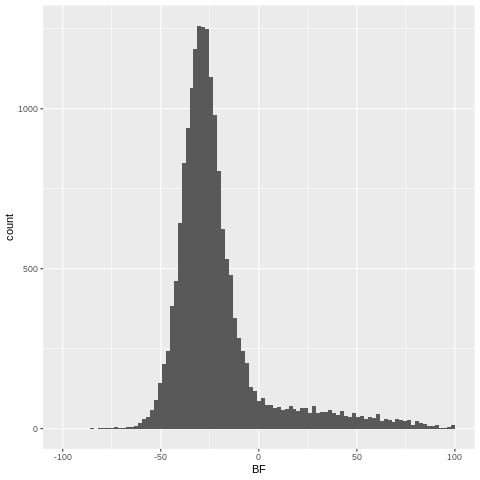

In [ ]:

%%R
ggplot(bayes_factors, aes(x = BF)) +
geom_histogram(bins = 100) +
xlim(-100, 100)

Lets overlay the essentiality of our known NEGs and CEGs to clarify things

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 28 rows containing non-finite outside the scale range (`stat_bin()`). 



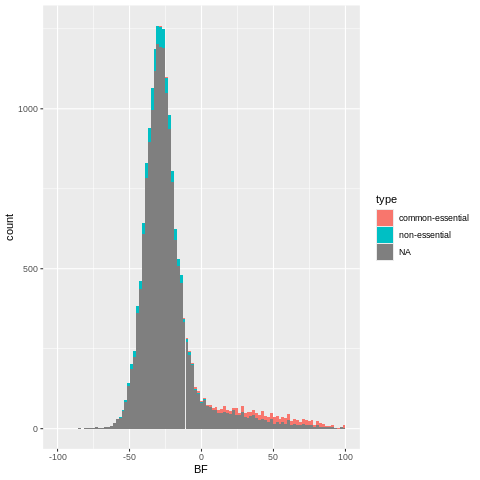

In [ ]:
%%R
annotated_bayes_data <- left_join(bayes_factors, essentiality_class, by = c("GENE" = "GENE"))
ggplot(annotated_bayes_data, aes(x = BF, fill = type)) +
geom_histogram(bins = 100) +
xlim(-100, 100)


In [ ]:
!python ./BAGEL.py pr -i hap1-essentials.bf -o hap1-essentials.pr -e CEGv2.txt -n NEGv1.txt

---

***Optional***


If you're condident in R and feeling ambitious see if you can generate a plot to compare the results of the two methods (MAGECK vs BAGEL). How well do the two methods correlate?

---

In [ ]:
%%R

## Enter your code here


**gscreend**

Another example of a more recently published CRISPR analysis tool is [gscreend](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1939-1), an R package that performs similar screen analysis to MAGECK. Gscreend accounts for the peculiarities of CRISPR knockout screen data (namely, population bottlenecks and the fact that the majority of changes in a CRISPR knockout screen are depletions).

**DESEQ2**

Whilst not strictly designed for CRISPR analysis, tools from the world of RNAseq such as DESEQ2 can also be configured for CRISPR analysis. These models are particularly strong for multi-factor experimental designs where you want to look at several variables at once.   

### Summary

Each of these methods (MAGECK, gscreend, BAGEL2, and others) will have different sensitivities and specificities (their abilities to distinguish true positives and true negatives from false positives and false negatives), but they should give broadly similar results. When running this kind of analysis, you may want to compare and contrast the tools or take a consensus from several of them.


# Step 6: Considerations for CRISPR screen analysis

In this example screen - we made a lot of assumptions about the biology going on in our cell population. Whilst these are often reasonable to make, it's important to remember that they might not hold in all cases!

---
## How quickly does CRISPR-Cas9 lethality manifest?

In this experiment, we used a "T0" pre-screen sample derived from a **transduced cell population** for our comparisons. However, it has been observed that using a sample of the **plasmid library** intended for transfection might be a superior reference. When researchers compared the counts of gRNAs targeting essential genes in plasmid and T0 samples, they found that essential gene guide counts were already reduced at T0 (Imkeller, K., Ambrosi, G., Boutros, M. et al, 2020). This suggests that gene editing can occur quickly and means that some of the essential gene depletion scores in our screen might be underestimates!

## Population bottlenecking

The act of splitting and discarding cells is an example of a "bottleneck" event where the population is shrunk. This reduces diversity in the cell population you are screening and can artificially increase the apparent depletion of rare guides in your experiment (see Figure 7). This could result in some guides being spuriously identified as essential and other guides being identified as enriched. The authors of gscreend suggest using it as your CRIPSR analysis tool might help mitigate this effect, but it's also important to consider how often and how severely you passage your cells during a screen.


---

**Figure 7: Bottlenecking in cell cutlure**

![Figure 7](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/bottlenecking.png?raw=1)

Taken from [Imkeller, K., Ambrosi, G., Boutros, M. et al. gscreend: modelling asymmetric count ratios in CRISPR screens to decrease experiment size and improve phenotype detection. Genome Biol 21, 53 (2020)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1939-1).

Note how over successive rounds of growth and passaging, the red mutant cells can become artificially over-represented in and the other coloured cells depleted from the population - even in the absence of a fitness effect.

---


## Copy-number affects gene essentiality

In our analysis, we treated genes with the implicit assumption that each gene had an equal number of copies in the genome. However, in cancer cells, genomic instability and copy number alterations are widespread, and this assumption may not hold true.

Several studies have shown that targeting CRISPR-Cas9 to regions with copy number gains causes more DNA double-strand breaks, triggering a stronger, gene-independent DNA damage response. This leads to cell-cycle arrest, and the net effect is that regions with copy number amplifications are much more likely to be depleted and appear as essential in a CRISPR knockout screen (see Figure 8).



---
**Figure 8: The effect of copy number on gene essentiality calculations**

![Figure 7: ](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/copy_number_plot.png?raw=1)

Taken from: [Aguirre AJ, Meyers RM, Weir BA, et al. Genomic Copy Number Dictates a Gene-Independent Cell Response to CRISPR/Cas9 Targeting. Cancer Discov. 2016;6(8):914-929. doi:10.1158/2159-8290.CD-16-0154](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4972686)

Note how guide scores are negatively correlated with copy number accross the locus.


Several tools have been developed to mitigate this effect. MAGECK, for instance, has an inbuilt copy-number adjustment tool that controls for copy number alterations. Alternatively, [CRISPRcleanR](https://www.sanger.ac.uk/tool/crisprcleanr/) applies a circular binary segmentation algorithm to identify genomic regions where sgRNA impact is correlated. This algorithm operates on the principle that neighbouring genes should not be equally essential, and when an entire neighbourhood of genes is found to be essential, it is likely due to a copy number alteration.


---
<a name="summary"></a>
# Conclusions


🎉🎉That's it for today! 🎉🎉


In many ways, we've only just scratched the surface, and there's plenty more to explore. You might want to dive into topics such as pre-filtering low-count guides from the dataset, identifying problematic samples using tools like a Principal Component Analysis, or performing multi-factorial analysis with tools like MAGECK-MLE. Alternatively, you can often reach out to a friendly bioinformatician for some assistance. Either way — happy screening!

As a reminder of what we covered in this session.

- Given a CRISPR counts matrix, you can use data wrangling tools like R or Python to quickly verify that sequencing samples meet your expectations.
- You'd expect samples to have similar overall guide distributions and similar total sequencing read.
- You can use tools such as MAGECK, BAGEL2, and gscreend to identify depleted or enriched guides in an experiment.
- These tools perform contrasts that compare guide RNA abundances in treatment vs. control samples and then aggregate this data at the gene level.
- By including positive and negative control genes in your guide RNA library, you can use metrics like NNMD to validate the success of a screen.
- Experimental and genomic factors may confound your experiment—so try to keep these in mind.



---
<a name="references"></a>
# References
- [Andersson, B. S., Beran, M., Pathak, S., Goodacre, A., Barlogie, B., & McCredie, K. B. (1987). Ph-positive chronic myeloid leukemia with near-haploid conversion in vivo and establishment of a continuously growing cell line with similar cytogenetic pattern. Cancer genetics and cytogenetics, 24(2), 335–343.](https://pubmed.ncbi.nlm.nih.gov/3466682)

- [Pacini, C., Dempster, J.M., Boyle, I. et al. Integrated cross-study datasets of genetic dependencies in cancer. Nat Commun 12, 1661 (2021)](https://www.nature.com/articles/s41467-021-21898-7)

- [Joshua M. Dempster, Jordan Rossen, Mariya Kazachkova, Joshua Pan, Guillaume Kugener, David E. Root, Aviad Tsherniak. Extracting Biological Insights from the Project Achilles Genome-Scale CRISPR Screens in Cancer Cell Lines](https://www.biorxiv.org/content/10.1101/720243v1)

- [Aguirre A.J., Meyers R.M., Weir B.A., et al. Genomic copy number dictates a gene-independent cell response to CRISPR-Cas9 targeting. Cancer Discov June 3 2016](https://pubmed.ncbi.nlm.nih.gov/27260156/)

- [Traver Hart and Jason Moffat. BAGEL: a computational framework for identifying essential genes from pooled library screens. BMC Bioinformatics, 2016 vol. 17 p. 164.](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-020-00809-3)

- [Aregger, M., Chandrashekhar, M., Tong, A.H.Y., Chan, K., Moffat, J. (2019). Pooled Lentiviral CRISPR-Cas9 Screens for Functional Genomics in Mammalian Cells. In: Singh, S., Venugopal, C. (eds) Brain Tumor Stem Cells. Methods in Molecular Biology, vol 1869. Humana Press, New York, NY.](https://link.springer.com/protocol/10.1007/978-1-4939-8805-1_15)

- [Joung, J., Konermann, S., Gootenberg, J. et al. Genome-scale CRISPR-Cas9 knockout and transcriptional activation screening. Nat Protoc 12, 828–863 (2017).](https://www.nature.com/articles/nprot.2017.016)

- [Imkeller, K., Ambrosi, G., Boutros, M. et al. gscreend: modelling asymmetric count ratios in CRISPR screens to decrease experiment size and improve phenotype detection. Genome Biol 21, 53 (2020).](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1939-1)

- [Li, W., Xu, H., Xiao, T. et al. MAGeCK enables robust identification of essential genes from genome-scale CRISPR/Cas9 knockout screens](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0554-4)